In [163]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [164]:
ratings = pd.read_csv(r"E:\DoAnPTIT\Data\not_spare_rating.csv")
ratings.head()

,product_id,content,customer_id,user_name,stars,comment_id
0,58441480,NaN,6024679,Nhung Phạm,5,4864338
1,58441480,NaN,11333255,Nguyen Nang Quang,4,4589409
2,3071851,"Sách có hình vẽ và nội dung rất đáng yêu, là m...",6292041,Phan Thi Hoan,5,2831147
3,3071851,Sách dễ thương. Bé nhà mình rất thích :),10905691,Yến Nhi,5,3477988
4,3071851,Sách dễ thương,7933673,Ngoc Dung,5,4633043


In [165]:
books = pd.read_csv(r"E:\DoAnPTIT\Data\clean_books.csv", usecols=['id', 'name', 'big_category', 'sub_category'])
books.head()

,id,name,big_category,sub_category
0,58390336,Python cơ bản,Sách Công Nghệ Thông Tin,Lập Trình
1,1664525,Giáo Trình Kỹ Thuật Lập Trình C Căn Bản Và Nân...,Sách Công Nghệ Thông Tin,Lập Trình
2,55573620,Giáo Trình Tự Học AutoCAD 2019 Thực Hành Bằng ...,Sách Công Nghệ Thông Tin,Thiết Kế - Đồ Họa
3,24889348,Lập trình hướng đối tượng JAVA core dành cho n...,Sách Công Nghệ Thông Tin,Lập Trình
4,37667006,Combo Giáo Trình Kỹ Thuật Lập Trình C Căn Bản ...,Sách Công Nghệ Thông Tin,Lập Trình


In [166]:
n_ratings = len(ratings)
n_books = ratings['product_id'].nunique()
n_users = ratings['customer_id'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique bookId's: {n_books}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per book: {round(n_ratings/n_books, 2)}")

Number of ratings: 20849
Number of unique bookId's: 5289
Number of unique users: 1382
Average number of ratings per user: 15.09
Average number of ratings per book: 3.94


In [167]:
user_freq = ratings[['customer_id', 'product_id']].groupby('customer_id').count().reset_index()
user_freq.columns = ['customer_id', 'n_ratings']
user_freq.sort_values('n_ratings', ascending=False)

,customer_id,n_ratings
514,5582356,148
684,7031251,84
416,1895509,68
499,5399042,65
1335,17612596,62
...,...,...
1111,13958756,10
1110,13916045,10
1109,13898138,10
1107,13841425,10


In [168]:
# idx = user_freq[user_freq['n_ratings']<10].customer_id.values

In [169]:
# ratings.drop(ratings[ratings['customer_id'].isin(idx)].index, inplace=True)

In [170]:
# ratings.info()

In [171]:
# ratings.to_csv('../Data/not_spare_rating.csv', index=False)

In [172]:
print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")

Mean number of ratings for a given user: 15.09.


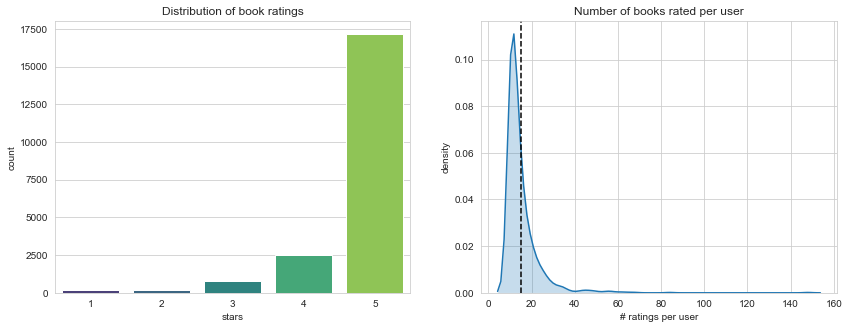

In [173]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="stars", data=ratings, palette="viridis")
plt.title("Distribution of book ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of books rated per user")
plt.show()

### Which book has the lowest and highest average rating?

In [174]:
mean_rating = ratings.groupby('product_id')[['stars']].mean()

lowest_rated = mean_rating['stars'].idxmin()
books.loc[books['id'] == lowest_rated].values

array([[591603, 'Quất Trung Bí Tân Chú (Tái Bản)',
        'Sách Kiến Thức Tổng Hợp', ' Thể Dục - Thể Thao']], dtype=object)

In [175]:
highest_rated = mean_rating['stars'].idxmax()
books.loc[books['id'] == highest_rated].values

array([[335337, 'Tôi Tài Giỏi - Bạn Cũng Thế', 'Sách kỹ năng sống',
        ' Sách nghệ thuật sống đẹp']], dtype=object)

In [176]:
ratings[ratings['product_id']==highest_rated]

,product_id,content,customer_id,user_name,stars,comment_id
13228,335337,Nhờ nó mà tôi đã đậu đại học. Nếu khôn...,920424,Oanh nguyen,5,409868
13229,335337,"Sách này là cuốn rất nổi tiếng của Adam Khoo, ...",861781,Trần Đức Tân,5,397778


this product has only 1 ratings. A better approach for evaluating book popularity is to look at the Bayesian average.

Bayesian Average
Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for book $i$. In this case, our prior will be the average rating across all books. By defintion, C represents "the typical dataset size". Let's make $C$ be the average number of ratings for a given book.

In [177]:
book_stats = ratings.groupby('product_id')[['stars']].agg(['count', 'mean'])
book_stats.columns = book_stats.columns.droplevel()

In [178]:
C = book_stats['count'].mean()
m = book_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('product_id')['stars'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['product_id', 'bayesian_avg']
book_stats = book_stats.merge(bayesian_avg_ratings, on='product_id')

In [179]:
books.rename(columns={'id': 'product_id'}, inplace=True)

In [180]:
book_stats = book_stats.merge(books[['product_id', 'name']])
book_stats.sort_values('bayesian_avg', ascending=False).head()

,product_id,count,mean,bayesian_avg,name
4638,54378885,36,5.0,4.971873,Thanh Gươm Diệt Quỷ Tập 6: Phát Xét Của Các Tr...
4431,51314912,30,5.0,4.966901,Thanh Gươm Diệt Quỷ - Tập 5: Xuống Địa Ngục
4365,50350077,25,5.0,4.961183,Thanh Gươm Diệt Quỷ Tập 4: Lưỡi Gươm Mạnh Mẽ
4975,58168943,23,5.0,4.958301,Thanh Gươm Diệt Quỷ Tập 11: Hỗn Chiến
2391,10392851,22,5.0,4.956694,Tôi Thấy Hoa Vàng Trên Cỏ Xanh


In [181]:
book_stats.sort_values('bayesian_avg', ascending=True).head()

,product_id,count,mean,bayesian_avg,name
3580,34180324,2,2.000000,3.801161,Chỉ Thời Gian Có Thể Cất Lời
2332,10076516,3,2.666667,3.829804,Long Thần Tướng - Tập 4
1699,3643493,3,2.666667,3.829804,At Home With Madame Chic - Thanh Lịch Từ Những...
3607,34935355,4,3.000000,3.851234,Đầu Tư - Kế Hoạch 12 Tháng Đến Với Tự Do Tài C...
1520,2619495,1,1.000000,3.963276,Mẹ Việt Dạy Con Bước Cùng Toàn Cầu (Tái Bản)


# Transform the data

The create_X() function outputs a sparse matrix X with four mapper dictionaries:

- user_mapper: maps user id to user index
- book_mapper: maps book id to book index
- user_inv_mapper: maps user index to user id
- book_inv_mapper: maps book index to book id

The X (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely.


In [182]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        book_mapper: dict that maps book id's to book indices
        book_inv_mapper: dict that maps book indices to book id's
    """
    N = df['customer_id'].nunique()
    M = df['product_id'].nunique()

    user_mapper = dict(zip(np.unique(df["customer_id"]), list(range(N))))
    book_mapper = dict(zip(np.unique(df["product_id"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["customer_id"])))
    book_inv_mapper = dict(zip(list(range(M)), np.unique(df["product_id"])))
    
    user_index = [user_mapper[i] for i in df['customer_id']]
    book_index = [book_mapper[i] for i in df['product_id']]

    X = csr_matrix((df["stars"], (book_index, user_index)), shape=(M, N))
    
    return X, user_mapper, book_mapper, user_inv_mapper, book_inv_mapper

In [183]:
X, user_mapper, book_mapper, user_inv_mapper, book_inv_mapper = create_X(ratings)

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below:

$$S=\frac{\text{# non-zero elements}}{\text{total elements}}$$

In [184]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.29%


Only 0.02 of cells in our user-item matrix are populated with ratings. But don't be discouraged by this sparsity! User-item matrices are typically very sparse. A general rule of thumb is that your matrix sparsity should be no lower than 0.5% to generate decent results.

## Writing your matrix to a file
We're going to save our user-item matrix for the next part of this tutorial series. Since our matrix is represented as a scipy sparse matrix, we can use the scipy.sparse.save_npz method to write the matrix to a file.

In [187]:
from scipy.sparse import save_npz

save_npz('../Data/user_item_matrix.npz', X)

# Finding similar movies using k-Nearest Neighbours
This approach looks for the $k$ nearest neighbours of a given movie by identifying $k$ points in the dataset that are closest to movie $m$. kNN makes use of distance metrics such as:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation

Although difficult to visualize, we are working in a M-dimensional space where M represents the number of movies in our X matrix.

In [188]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(product_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar movie ID's
    """
    neighbour_ids = []
    
    book_ind = book_mapper[product_id]
    book_vec = X[book_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(book_vec, (np.ndarray)):
        book_vec = book_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(book_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(book_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [190]:
book_titles = dict(zip(books['product_id'], books['name']))

book_id = 335337

similar_ids = find_similar_movies(book_id, X, k=10)
book_title = book_titles[book_id]

print(f"Because you watched {book_title}")
for i in similar_ids:
    print(book_titles[i])

Because you watched Tôi Tài Giỏi - Bạn Cũng Thế
Dạy Con Làm Giàu VII - Ai Đã Lấy Tiền Của Tôi? (Tái Bản 2012)
Đột Phá Mindmap - Tư Duy Đọc Hiểu Môn Ngữ Văn Bằng Hình Ảnh Lớp 12
Luyện Siêu Trí Nhớ Từ Vựng Tiếng Anh (Dùng Kèm App)
Đời Ngắn Đừng Ngủ Dài
Ba Người Thầy Vĩ Đại
Cuốn Sách Nhỏ Cho Nhà Lãnh Đạo Lớn
Tình Bạn Là...
Trâm - Nữ Hoạn Quan (Tái Bản 2018)
Hãy Chăm Sóc Mẹ (Tái Bản)
Hẹn Bạn Trên Đỉnh Thành Công (Tái bản 2016)


In [191]:
book_titles = dict(zip(books['product_id'], books['name']))

book_id = 335337

similar_ids = find_similar_movies(book_id, X, k=10, metric='euclidean')
book_title = book_titles[book_id]

print(f"Because you watched {book_title}")
for i in similar_ids:
    print(book_titles[i])

Because you watched Tôi Tài Giỏi - Bạn Cũng Thế
Dạy Con Làm Giàu VII - Ai Đã Lấy Tiền Của Tôi? (Tái Bản 2012)
Đột Phá Mindmap - Tư Duy Đọc Hiểu Môn Ngữ Văn Bằng Hình Ảnh Lớp 12
Tết Việt Nam qua tranh dân gian
Alexandre De Rhodes Và Vấn Đề Chữ Quốc Ngữ - Tiểu Luận (Bùi Kha) 
Ngay Bây Giờ Hoặc Không Bao Giờ (Tái Bản 2018)
The Langmaster - Từ Vựng Tiếng Anh Theo Chủ Điểm (Tái Bản Kèm CD)
Duy Tân Thập Kiệt - Mười Nhân Vật Kiệt Xuất Của Minh Trị Duy Tân
Sách Phương Pháp Định Tội Danh Với 538 Tội Phạm Quy Định Trong Bộ Luật Hình Sự 2015, Được Sửa Đổi, Bổ Sung 2017 (Tái Bản Có Bổ Sung)
Khái Lược Văn Minh Luận
Kanban - Quản Lý Công Việc Hiệu Quả


# Building a Recommender System with Implicit Feedback